<a href="https://colab.research.google.com/github/abezen/matthewparker/blob/main/amazon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np  # numpy for math
import pandas as pd  # for dataframes and csv files
import matplotlib.pyplot as plt  # for plotting
from matplotlib import animation  # animate 3D plots
from mpl_toolkits.mplot3d import Axes3D  # 3D plots
import os


In [3]:
# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn import manifold


In [5]:
# TensorFlow and Keras
import tensorflow as tf
# Removed experimental import as it could not be resolved
from tensorflow import keras
from keras import preprocessing
items_csv = pd.read_csv('./data/items.csv')
items_csv.head(3)
items_csv.shape
items_features = items_csv.copy().dropna()  # drop rows with NaN values


In [6]:
items_features.pop("url")
items_features.pop("image")
items_features.pop("reviewUrl")
#items_features.pop("originalPrice")
p_labels = items_features.pop("asin")

df = pd.DataFrame(items_features)
df.to_csv('./data/Copy_data.csv', index = False)



In [7]:
inputs = {}
for name, column in items_features.items():
    dtype = column.dtype
    if dtype == object:
        dtype = tf.string
    else:
        dtype = tf.float32
    inputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=dtype)

print(inputs)



{'brand': <KerasTensor shape=(None, 1), dtype=string, sparse=False, name=brand>, 'title': <KerasTensor shape=(None, 1), dtype=string, sparse=False, name=title>, 'rating': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=rating>, 'totalReviews': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=totalReviews>, 'price': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=price>, 'originalPrice': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=originalPrice>}


In [8]:
numeric_inputs = {name: input for name, input in inputs.items() if input.dtype == tf.float32}

x = tf.keras.layers.Concatenate()(list(numeric_inputs.values()))
# norm = preprocessing.Normalization()
norm = keras.layers.Normalization()
norm.adapt(np.array(items_features[numeric_inputs.keys()]))
all_numeric_inputs = norm(x)
preprocessed_inputs = [all_numeric_inputs]

all_numeric_inputs


<KerasTensor shape=(None, 4), dtype=float32, sparse=False, name=keras_tensor_1>

In [9]:
count = 0
for name, input in inputs.items():
    if input.dtype != tf.string:
        continue

    lookup = keras.layers.StringLookup(vocabulary=np.unique(items_features[name]))
    vocabulary=np.unique(items_features[name])
    count += 1
    scount = str(count)
    flname = "./data/" + scount + ".csv"
    df = pd.DataFrame(vocabulary )
    df.to_csv(flname, index=False)
    size = np.size(vocabulary)
    print(size)

    one_hot = keras.layers.CategoryEncoding(num_tokens=size)

    x = lookup(input)
    x = one_hot(x)

    preprocessed_inputs.append(x) # append preprocessed feature to features list
    print(preprocessed_inputs)


10
[<KerasTensor shape=(None, 4), dtype=float32, sparse=False, name=keras_tensor_1>, <KerasTensor shape=(None, 10), dtype=float32, sparse=False, name=keras_tensor_3>]
714
[<KerasTensor shape=(None, 4), dtype=float32, sparse=False, name=keras_tensor_1>, <KerasTensor shape=(None, 10), dtype=float32, sparse=False, name=keras_tensor_3>, <KerasTensor shape=(None, 714), dtype=float32, sparse=False, name=keras_tensor_5>]


In [10]:
print(preprocessed_inputs)


[<KerasTensor shape=(None, 4), dtype=float32, sparse=False, name=keras_tensor_1>, <KerasTensor shape=(None, 10), dtype=float32, sparse=False, name=keras_tensor_3>, <KerasTensor shape=(None, 714), dtype=float32, sparse=False, name=keras_tensor_5>]


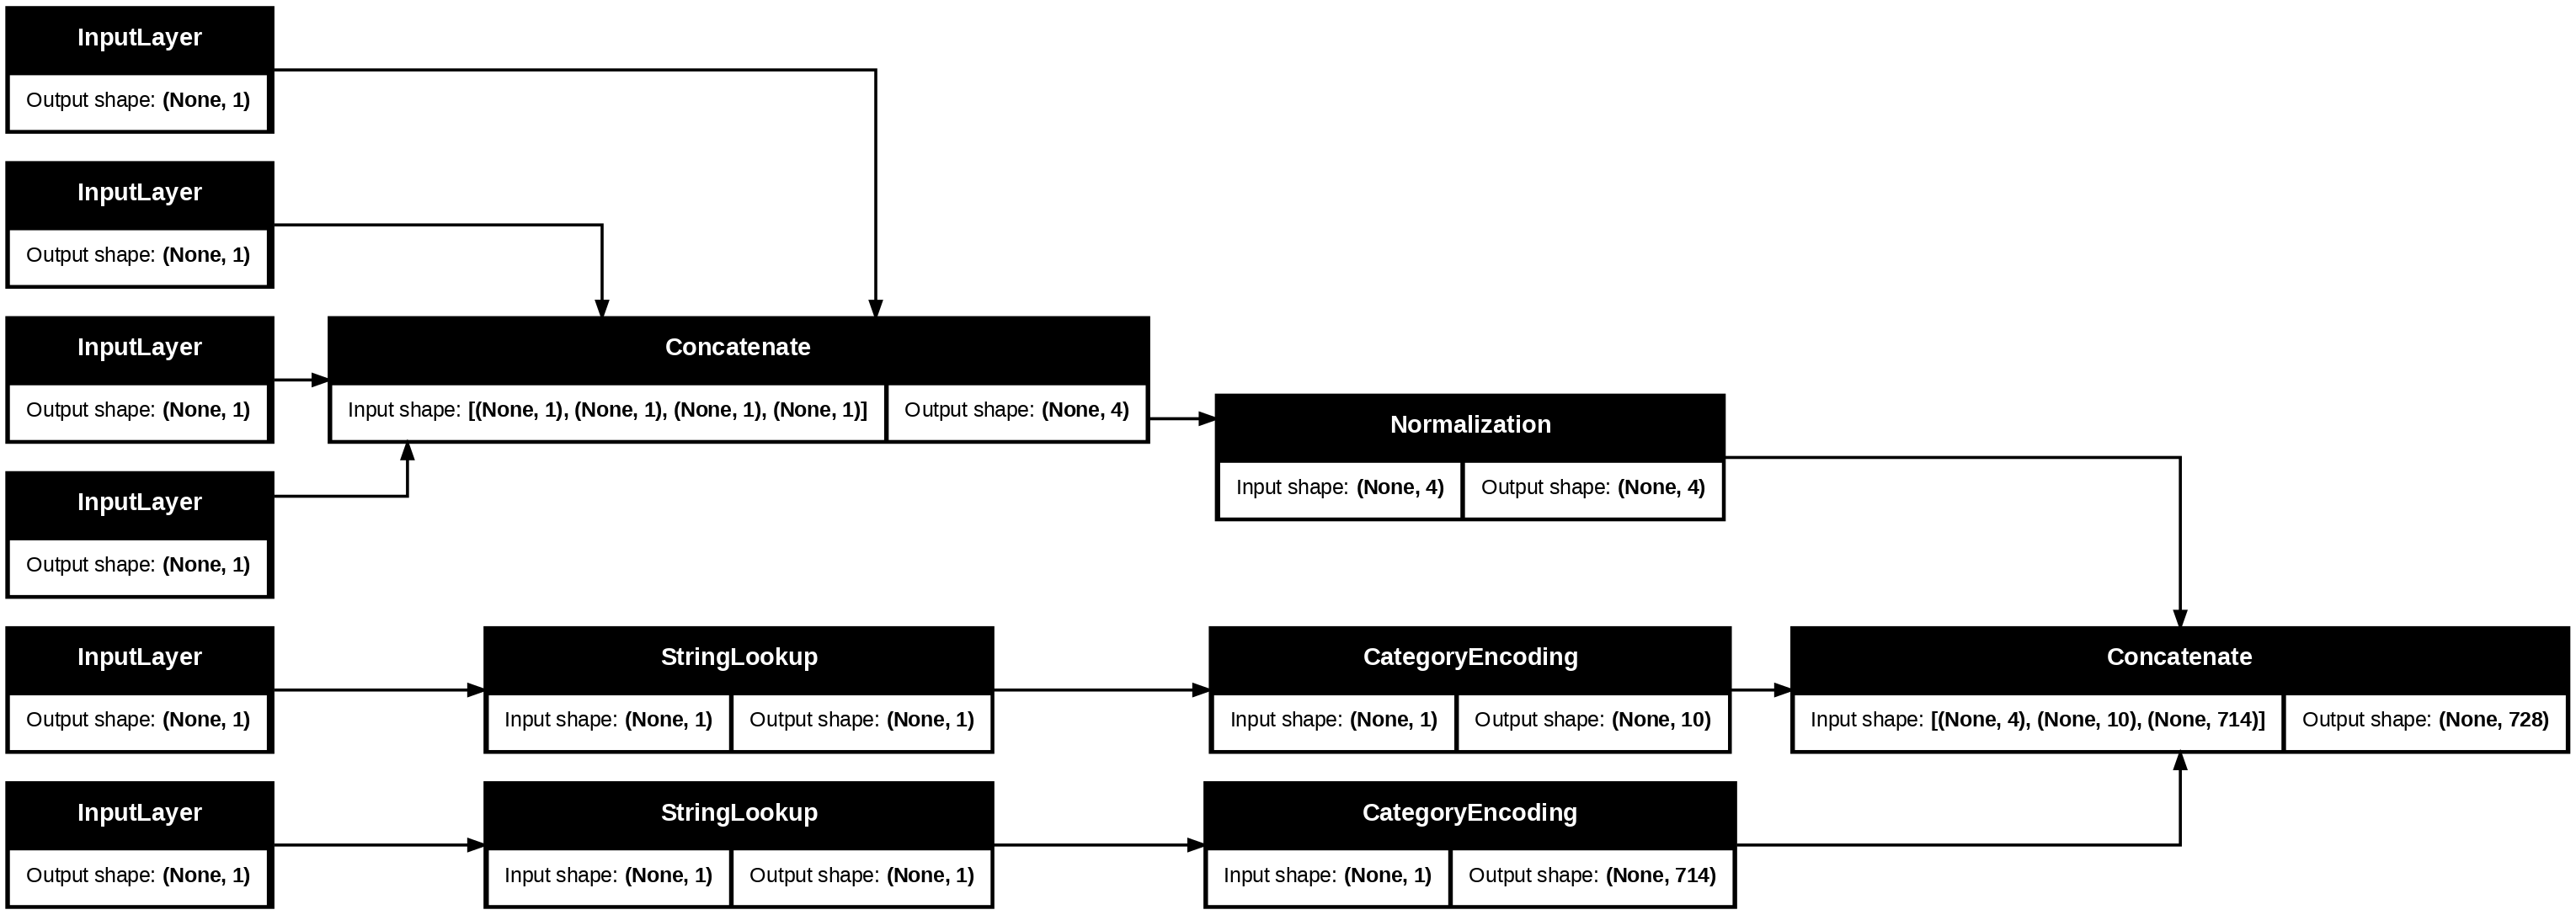

In [11]:
preprocessed_inputs_cat = keras.layers.Concatenate()(preprocessed_inputs)
preprocessing_layer = tf.keras.Model(inputs, preprocessed_inputs_cat, name="ProcessData")


tf.keras.utils.plot_model(model=preprocessing_layer, rankdir="LR", dpi=130, show_shapes=True, to_file="./data/processing.png")


In [12]:
items_features_dict = {name: np.array(value) for name, value in items_features.items()}


two_sample_dict = {name:values[1:3, ] for name, values in items_features_dict.items()}
two_sample_dict

print(two_sample_dict)


{'brand': array(['Motorola', 'Motorola'], dtype=object), 'title': array(['MOTOROLA C168i AT&T CINGULAR PREPAID GOPHONE CELL PHONE',
       'Motorola i335 Cell Phone Boost Mobile'], dtype=object), 'rating': array([2.7, 3.3]), 'totalReviews': array([22, 21]), 'price': array([99.99,  0.  ]), 'originalPrice': array([0., 0.])}


In [13]:
# apply the preprocessing layer
two_sample_fitted = preprocessing_layer(two_sample_dict)

two_sample_fitted

print(two_sample_fitted)

# This is the size of our input data
full_dim = two_sample_fitted.shape.as_list()[1]

# these are the downsampling/upsampling dimensions
encoding_dim1 = 128
encoding_dim2 = 16
encoding_dim3 = 3 # we will use these 3 dimensions for clustering


tf.Tensor(
[[-1.4144895  -0.50023943 -0.67571497 ...  0.          0.
   0.        ]
 [-0.57760113 -0.50619656 -1.1760992  ...  0.          0.
   0.        ]], shape=(2, 728), dtype=float32)


In [14]:
# This is our encoder input
encoder_input_data = keras.Input(shape=(full_dim,))

# the encoded representation of the input
encoded_layer1 = keras.layers.Dense(encoding_dim1, activation='relu')(encoder_input_data)
encoded_layer2 = keras.layers.Dense(encoding_dim2, activation='relu')(encoded_layer1)
# Note that encoded_layer3 is our 3 dimensional "clustered" layer, which we will later use for clustering
encoded_layer3 = keras.layers.Dense(encoding_dim3, activation='relu', name="ClusteringLayer")(encoded_layer2)

encoder_model = keras.Model(encoder_input_data, encoded_layer3)


In [15]:
# the reconstruction of the input
decoded_layer3 = keras.layers.Dense(encoding_dim2, activation='relu')(encoded_layer3)
decoded_layer2 = keras.layers.Dense(encoding_dim1, activation='relu')(decoded_layer3)
decoded_layer1 = keras.layers.Dense(full_dim, activation='sigmoid')(decoded_layer2)

# This model maps an input to its autoencoder reconstruction
autoencoder_model = keras.Model(encoder_input_data, outputs=decoded_layer1, name="Encoder")


In [16]:
# compile the model
autoencoder_model.compile(optimizer="RMSprop", loss=tf.keras.losses.MeanSquaredError, metrics=['accuracy'])
tf.keras.utils.plot_model(model=autoencoder_model, rankdir="LR", dpi=130, show_shapes=True, to_file="./data/autoencoder.png")

# process the inputs

p_items = preprocessing_layer(items_features_dict)

# split into training and testing sets (80/20 split)
train_data, test_data, train_labels, test_labels = train_test_split(p_items.numpy(), p_labels, train_size=0.8, random_state=5)

In [17]:
# fit the model using the training data
history = autoencoder_model.fit(train_data, train_data, epochs=1000, batch_size=256, shuffle=True, validation_data=(test_data, test_data))


Epoch 1/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 0.0150 - loss: 0.2552 - val_accuracy: 0.0347 - val_loss: 0.2553
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.0664 - loss: 0.2544 - val_accuracy: 0.0694 - val_loss: 0.2546
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.0818 - loss: 0.2537 - val_accuracy: 0.0694 - val_loss: 0.2539
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.0758 - loss: 0.2529 - val_accuracy: 0.0764 - val_loss: 0.2532
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.0720 - loss: 0.2524 - val_accuracy: 0.0694 - val_loss: 0.2525
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.0781 - loss: 0.2516 - val_accuracy: 0.0694 - val_loss: 0.2519
Epoch 7/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.0727 - loss: 0.2509 - val_accuracy: 0.0694 - val_loss: 0.2512
Epoch 8/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.0653 - loss: 0.2503 - val_accuracy: 0.0625 - 